# Epidemiology Example

The Covid-19 Datalake provides line list records which have been crowd-sourced from data about known infections. Here, we show how to fetch the data from the Datalake, and plot the most common symptoms of these patients for various populations. 

## Load python modules

We first load the necessary python modules. We use `requests`, `pandas`, `numpy`, and `matplotlib` as external libraries.

In [120]:
# Load necessary Python Modules

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re

## Global variables for API calls

All API calls we will make need a set of header information. We define that here. Additionally, we define the base url for our API calls.

In [121]:
# Necessary headers
headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

base_url = "https://api.c3.ai/covid/api/1"

## Define data fetching function

This function fetches data varying the offset until all data from a given fetch query is gathered. Since the covid-19 Datalake public API currently limits fetches to at most 2000 entries, we will need to make multiple fetches until all data for that call has been gathered.

In [3]:
def fetch_data(url, headers=None, data=None):
    hasMore = True
    
    data['spec']['limit'] = -1
    data['spec']['offset'] = 0
    
    results = []
    
    while hasMore:
        r = requests.post(url,
                          headers=headers,
                          data=json.dumps(data))
        if r.status_code != 200:
            raise RuntimeError("Problem fetching data! {} ({})".format(r.text, r.request.body))
        
        res_json = json.loads(r.text)
        hasMore = res_json['hasMore']
        data['spec']['offset'] += res_json['count']
        
        results += res_json['objs']
    
    result_df = pd.DataFrame(results)
    result_df = result_df.set_index('id')
    return result_df

## Fetch Line List data

Here, we fetch the line list data from the `linelistrecord/fetch` API op top of the base URL defined earlier. We select a number of features we want to gather from the dataset as well so we can perform more interesting data analysis.

In [122]:
data = {
    'spec': {
        'include': 'symptoms, gender, age, ageRange, outcome, didDie, didRecover, symptomStartDate, caseConfirmationDate, outcomeDate, hospitalAdmissionDate',
        'limit': -1,
        'offset': 0,
    }
}

linelistrecord_df = fetch_data(os.path.join(base_url, 'linelistrecord', 'fetch'),
                               headers=headers,
                               data=data)

## Build Helper functions for data analysis and plotting

In the following two cells, we define a number of helper functions for data analysis and finally data plotting.

First, we define two functions for gathering a list of most common symptoms, and producing some final value from them. Since the symptom column stores a text-based comma-separated list, we must iterate through the `symptom` column of the dataset and break apart the text into tokens defining the individual symptoms taking care to not separate phrases like "acute repiratory distress syndrome".

Once a list of the most common symptoms is built, we can count how many patients in the dataset of those symptoms, and plot our final summaries. Helper functions which handle this part of the process are in the second cell in this section.

In [123]:
# Build function to produce the Percentage
def build_symptom_percentages(df, num=20):
    from collections import defaultdict
    if 'symptoms' not in df.columns:
        raise KeyError("'symptoms' not in the DataFrame")
    
    all_symptoms = defaultdict(lambda: 0)
    
    full_symptoms = df[df.symptoms.notna()].symptoms.values
    
    for symptomlist in full_symptoms:
        symptoms = re.split('[,;:][ ]?', symptomlist.strip().lower())
        for symptom in symptoms:
            all_symptoms[symptom] += 1

    symptoms = list(all_symptoms.keys())
    symptoms = sorted(symptoms, key= lambda s: all_symptoms[s], reverse=True)
    
    most_common_symptoms = symptoms[:num]
    
    most_common_symptom_counts = {}
    for symptom in symptoms[:num]:
        most_common_symptom_counts[symptom] = 0
    most_common_symptom_counts['Uncommon'] = 0
    
    for symptom_list in full_symptoms:
        symptoms = re.split('[,;:][ ]?', symptom_list.strip().lower())
        for symptom in symptoms:
            if symptom in most_common_symptoms:
                most_common_symptom_counts[symptom] += 1
            elif symptom != '':
                most_common_symptom_counts['Uncommon'] += 1
                
    symptom_fractions = {symptom:(most_common_symptom_counts[symptom]/len(full_symptoms))*100. for symptom in most_common_symptom_counts}
    
    return symptom_fractions

# Build function to produce the Percentage
def build_symptom_counts(df, num=20):
    from collections import defaultdict
    if 'symptoms' not in df.columns:
        raise KeyError("'symptoms' not in the DataFrame")
    
    all_symptoms = defaultdict(lambda: 0)
    
    full_symptoms = df[df.symptoms.notna()].symptoms.values
    
    for symptomlist in full_symptoms:
        symptoms = re.split('[,;:][ ]?', symptomlist.strip().lower())
        for symptom in symptoms:
            all_symptoms[symptom] += 1

    symptoms = list(all_symptoms.keys())
    symptoms = sorted(symptoms, key= lambda s: all_symptoms[s], reverse=True)
    
    most_common_symptoms = symptoms[:num]
    
    most_common_symptom_counts = {}
    for symptom in symptoms[:num]:
        most_common_symptom_counts[symptom] = 0
    most_common_symptom_counts['Uncommon'] = 0
    
    for symptom_list in full_symptoms:
        symptoms = re.split('[,;:][ ]?', symptom_list.strip().lower())
        for symptom in symptoms:
            if symptom in most_common_symptoms:
                most_common_symptom_counts[symptom] += 1
            elif symptom != '':
                most_common_symptom_counts['Uncommon'] += 1
                
    return most_common_symptom_counts

def keys_in_order(Dict):
    keys = list(Dict.keys())
    return sorted(keys, key=lambda k: Dict[k], reverse=True)

In [127]:
def plot_symptom_percentages(df, ylabel='Percent of patients with Common Symptom',
                             title='Percent of patients with Common Symptoms'):
    symptom_percentages = build_symptom_percentages(df)
    
    _, ax = plt.subplots(1, figsize=(15, 5))
    keys = keys_in_order(symptom_percentages)
    ax.bar(keys, [symptom_percentages[key] for key in keys])
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.xticks(rotation=-30, horizontalalignment='left')
    plt.grid(which='major', axis='y')
    plt.show()

def plot_symptom_counts(df, ylabel="Number of Patients with Common Symptoms",
                        title="Number of Patients with Common Symptoms"):
    symptom_percentages = build_symptom_counts(df)
    
    _, ax = plt.subplots(1, figsize=(15, 5))
    keys = keys_in_order(symptom_percentages)
    ax.bar(keys, [symptom_percentages[key] for key in keys])
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.xticks(rotation=-30, horizontalalignment='left')
    plt.grid(which='major', axis='y')
    plt.show()

## Plot Common Symptom Results

Now we plot the most common symptoms in the Covid-19 line list record Database. We separate the plots into a couple of sub-populations.

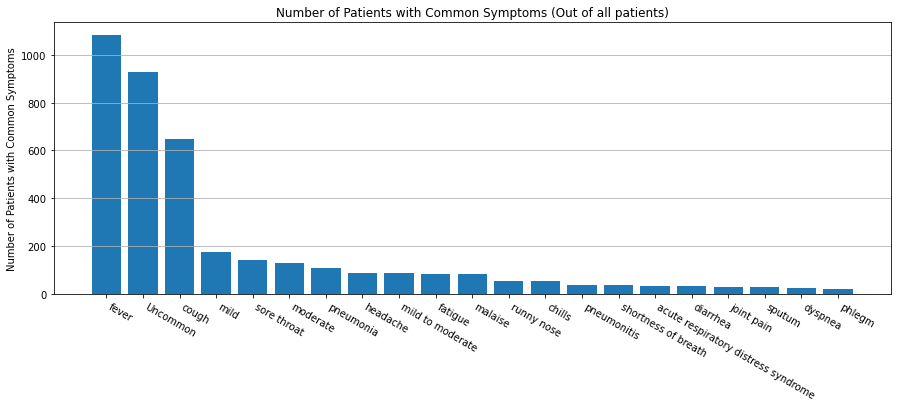

In [129]:
plot_symptom_counts(linelistrecord_df, title="Number of Patients with Common Symptoms (Out of all patients)")

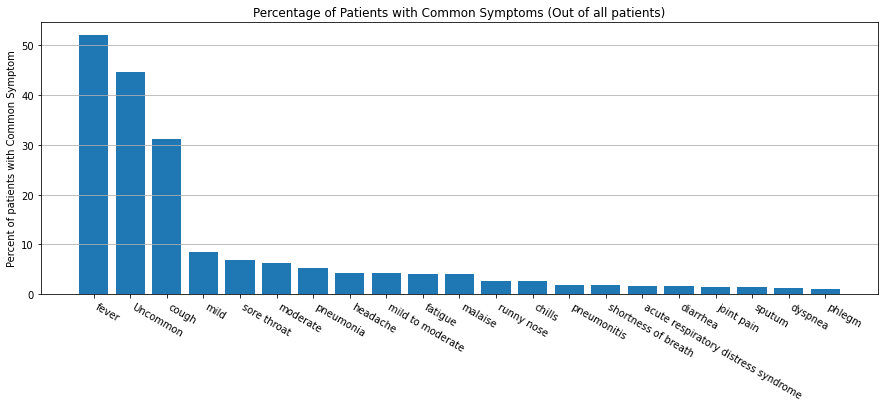

In [130]:
plot_symptom_percentages(linelistrecord_df, title="Percentage of Patients with Common Symptoms (Out of all patients)")

### Restrict the dataset to those entries containing outcome, symptom, age, and death information.

In [131]:
more_complete_subset_df = linelistrecord_df[linelistrecord_df.outcome.notna() & linelistrecord_df.symptoms.notna() & linelistrecord_df.age.notna() & linelistrecord_df.didDie.notna() & linelistrecord_df.didRecover.notna() & (linelistrecord_df.didRecover | linelistrecord_df.didDie)]

In [132]:
more_complete_subset_df

,age,gender,caseConfirmationDate,meta,version,symptomStartDate,hospitalAdmissionDate,outcome,didDie,didRecover,outcomeDate,symptoms,ageRange
id,,,,,,,,,,,,,
00f17bd2-871f-4ec3-a3b3-2fff026bf2f1,46.0,male,2020-01-21T00:00:00Z,"{'fetchInclude': '[symptoms,gender,age,ageRang...",65537,2020-01-04T00:00:00Z,2020-01-17T00:00:00Z,discharged,False,True,NaN,fever,NaN
00fba5f2-f3ae-4c11-88fb-1493b639246b,44.0,female,2020-01-21T00:00:00Z,"{'fetchInclude': '[symptoms,gender,age,ageRang...",65537,2020-01-15T00:00:00Z,2020-01-15T00:00:00Z,discharged,False,True,2020-01-29T00:00:00Z,"fatigue, fever",NaN
043c43c9-83ee-4967-8fde-a2ad847a9437,39.0,male,2020-01-22T00:00:00Z,"{'fetchInclude': '[symptoms,gender,age,ageRang...",65537,2020-01-21T00:00:00Z,2020-01-21T00:00:00Z,died,True,False,NaN,"cough, fever",NaN
0526e980-ede6-4d99-9f52-e1e2fc00c285,65.0,male,NaN,"{'fetchInclude': '[symptoms,gender,age,ageRang...",65537,2020-01-05T00:00:00Z,2020-01-11T00:00:00Z,died,True,False,2020-01-21T00:00:00Z,"fatigue, shortness of breath",NaN
07c7d91e-e344-46b3-8f89-954ea56b37e7,81.0,male,NaN,"{'fetchInclude': '[symptoms,gender,age,ageRang...",65537,2020-01-10T00:00:00Z,2020-01-13T00:00:00Z,died,True,False,2020-01-21T00:00:00Z,fever,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
f8405a9f-70aa-480f-86ea-4ec65f956449,56.0,male,2020-03-20T00:00:00Z,"{'fetchInclude': '[symptoms,gender,age,ageRang...",65537,NaN,NaN,died,True,False,2020-03-19T00:00:00Z,septic shock:pneumonia,NaN
f943e457-fb11-4655-8ff0-ab91f7e63810,78.0,male,2020-03-21T00:00:00Z,"{'fetchInclude': '[symptoms,gender,age,ageRang...",65537,NaN,NaN,died,True,False,2020-03-22T00:00:00Z,acute respiratory distress syndrome:septic sho...,NaN
fba4e347-a9b8-403f-8822-61f14be811f6,66.0,male,NaN,"{'fetchInclude': '[symptoms,gender,age,ageRang...",65537,2020-01-11T00:00:00Z,2020-01-11T00:00:00Z,died,True,False,2020-01-21T00:00:00Z,"cough, fever",NaN


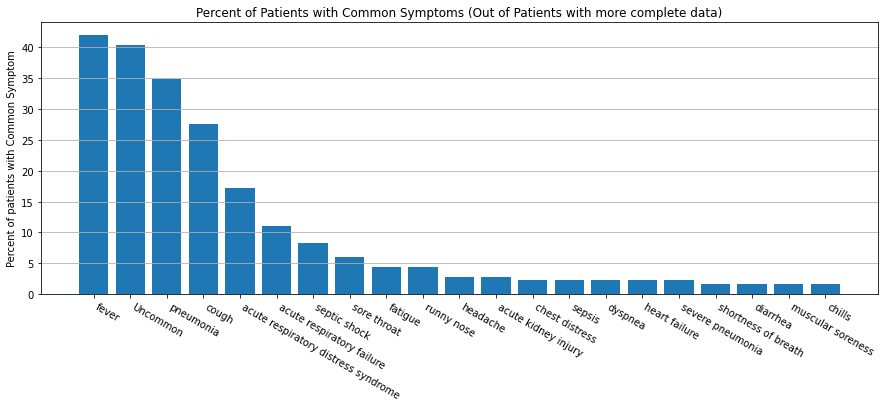

In [134]:
plot_symptom_percentages(more_complete_subset_df, title="Percent of Patients with Common Symptoms (Out of Patients with more complete data)")

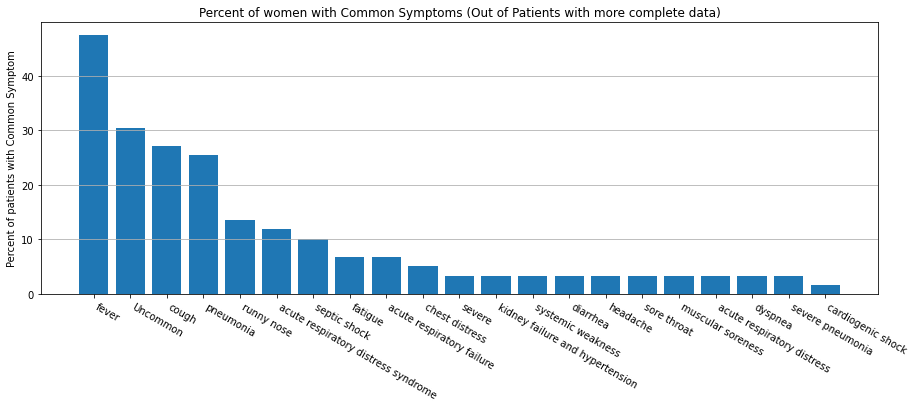

In [135]:
plot_symptom_percentages(more_complete_subset_df[more_complete_subset_df.gender == 'female'],
                         title="Percent of women with Common Symptoms (Out of Patients with more complete data)")

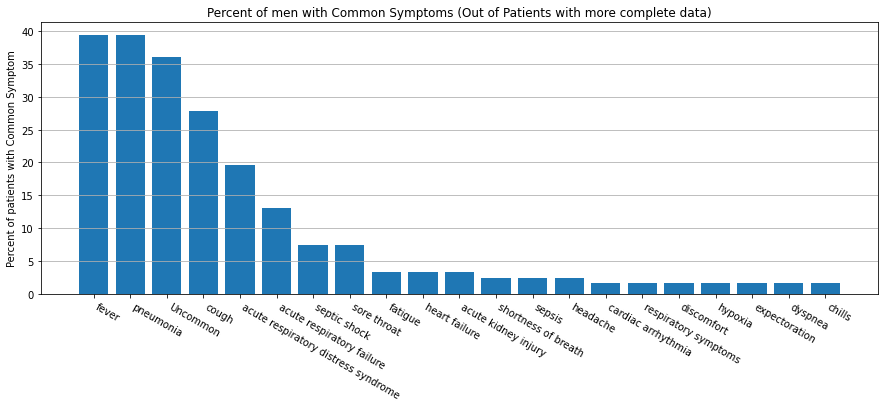

In [136]:
plot_symptom_percentages(more_complete_subset_df[more_complete_subset_df.gender == 'male'],
                         title="Percent of men with Common Symptoms (Out of Patients with more complete data)")

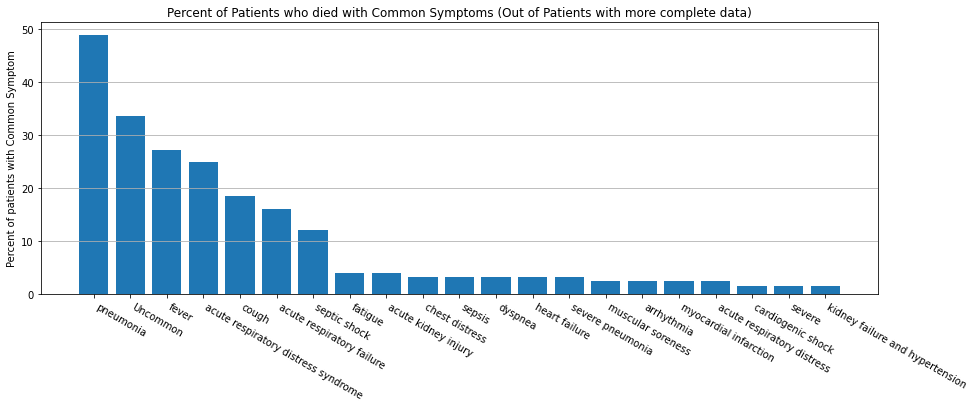

In [137]:
plot_symptom_percentages(more_complete_subset_df[more_complete_subset_df.didDie.astype(bool)],
                         title="Percent of Patients who died with Common Symptoms (Out of Patients with more complete data)")

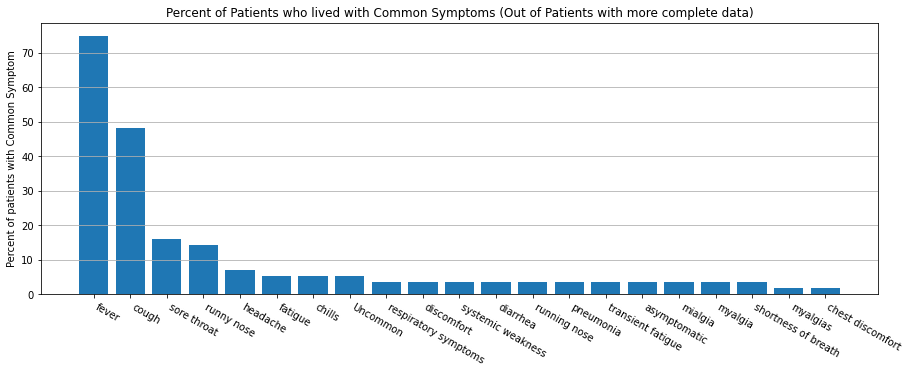

In [138]:
plot_symptom_percentages(more_complete_subset_df[~(more_complete_subset_df.didDie.astype(bool))],
                         title="Percent of Patients who lived with Common Symptoms (Out of Patients with more complete data)")